In [1]:
import numpy as np
import cupy as cp
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
import h5py
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")

sys.path.insert(0, '..')
from utils import *
from rec import Rec

In [2]:
bin = 1
ntheta = 1440

In [3]:
with h5py.File(f'/data/vnikitin/ESRF/ID16A/20240924_h5_syn/AtomiumS2/AtomiumS2_codedht_random_007nm/data_corrected.h5') as fid:
    sx0 = fid['/exchange/sx0'][0]    
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]    
    focusToDetectorDistance = fid['/exchange/focusdetectordistance'][0]    
    z10 = fid['/exchange/z1'][0]    
    
    theta = fid['/exchange/theta'][::7200//ntheta]/180*np.pi
    shifts_cor = fid['/exchange/shifts_cor'][::7200//ntheta]
    shifts_code = fid['/exchange/shifts_code'][::7200//ntheta]    
    cdata2 = fid['/exchange/cdata2'][::7200//ntheta]
    data = fid['/exchange/data'][::7200//ntheta]        

    cdata = fid['/exchange/cdata'][:]    
    ref = fid['/exchange/ref'][:]
    q = fid['/exchange/prb'][:]
    code = fid['/exchange/code'][:]    
    

for k in range(bin):
    data = 0.5*(data[:,::2]+data[:,1::2])
    data = 0.5*(data[:,:,::2]+data[:,:,1::2])
    ref = 0.5*(ref[::2]+ref[1::2])
    ref = 0.5*(ref[:,::2]+ref[:,1::2])
    cdata = 0.5*(cdata[::2]+cdata[1::2])
    cdata = 0.5*(cdata[:,::2]+cdata[:,1::2])
    cdata2 = 0.5*(cdata2[:,::2]+cdata2[:,1::2])
    cdata2 = 0.5*(cdata2[:,:,::2]+cdata2[:,:,1::2])
    q = 0.5*(q[::2]+q[1::2])
    q = 0.5*(q[:,::2]+q[:,1::2])
    code = 0.5*(code[::2]+code[1::2])
    code = 0.5*(code[:,::2]+code[:,1::2])
shifts_cor/=2**bin
shifts_code/=2**bin

In [4]:
z1c = -17.75e-3
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
z1 = z10 - sx0
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications)
magnifications2 = z1/z1c
distancec = (z1-z1c)/(z1c/z1)#magnifications2
show = True

In [5]:
args = SimpleNamespace()
args.npos = 1
args.ngpus = 4
args.lam = 0

args.n = 2048//2**bin
voxelsize *= 2048/args.n

args.ntheta = ntheta
args.ncode = 8704*args.n//2048
args.pad = args.n // 8
args.npsi = args.n + 2 * args.pad
args.nq = args.n + 2 * args.pad
args.ex = 8
args.npatch = args.nq + 2 * args.ex
args.nchunk = 8

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.distancec = distancec
args.eps = 1e-12
args.rho = [1, 20, 10]
args.crop = 0#2 * args.pad
args.path_out = f"/data/vnikitin/ESRF/ID16A/20240924_rec0224//AtomiumS2/AtomiumS2_codedht_random_007nm/{args.n}_{args.lam}_{args.rho[1]}_{args.rho[2]}"
args.show = True

args.niter=512
args.vis_step=4
args.err_step=4
args.method = "BH-CG"
args.rotation_axis=157*args.n/256

args.theta = theta
# create class
cl_rec = Rec(args)


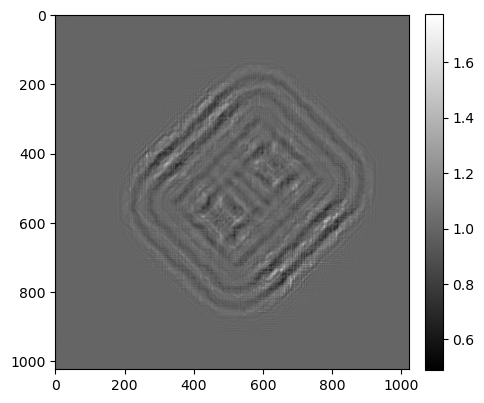

In [6]:
rdata=data/cdata2
mshow(rdata[-1],show)

In [ ]:
def Paganin(data, wavelength, voxelsize, delta_beta, alpha):
    n = data.shape[-1]
    fx = cp.fft.fftfreq(2*n, d=voxelsize).astype("float32")
    [fx, fy] = cp.meshgrid(fx, fx)
    data = np.pad(data,((n//2,n//2),(n//2,n//2)),'edge')
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distance * cp.pi * (delta_beta) * (fx**2 + fy**2)
    numerator = taylorExp * (rad_freq)
    denominator = taylorExp**2 + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = delta_beta * 0.5 * phase
    phase = phase[n//2:-n//2,n//2:-n//2]
    return phase

def rec_init(rdata):
    recMultiPaganin = np.zeros([args.ntheta,args.npsi, args.npsi], dtype="float32")
    for j in range(0, args.ntheta):
        r = cp.array(rdata[j])
        r = cp.pad(r,((args.pad,args.pad),(args.pad,args.pad)),'edge')
        
        r = Paganin(r, wavelength, voxelsize, 20.05, 1e-12)     
        r-=0.5*(np.mean(r[:args.n//32,:args.n//32])+np.mean(r[-args.n//32:,-args.n//32:]))
        recMultiPaganin[j] = r.get()   

    recMultiPaganin = np.exp(1j * recMultiPaganin)
    return recMultiPaganin

psi_init = rec_init(rdata)
mshow_polar(psi_init[-1],args.show)

In [8]:
psi_data = np.log(psi_init)/1j
rpsi = shifts_cor

In [ ]:
u_init = cl_rec.rec_tomo(psi_data,rpsi,32)
np.save(f'/data/tmp/u_init{args.n}',u_init)
u_init = np.load(f'/data/tmp/u_init{args.n}.npy')
mshow_complex(u_init[u_init.shape[0]//2],True)

In [ ]:
vars = {}
vars["code"] = cp.array(code)
vars["u"] = np.array(u_init)
vars["Ru"] = cl_rec.R(vars['u'])
vars["psi"] = cl_rec.expR(vars['Ru'])
vars["q"] = cp.array(q)
vars["ri"] = np.round(shifts_code).astype("int32")
vars["r"] = np.array(shifts_code - vars["ri"]).astype("float32")#+(np.random.random(shifts_code.shape).astype('float32')-0.5)
vars["rpsi"] = np.array(shifts_cor).astype("float32")
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])
cl_rec.rho = [1,20,10]
vars = cl_rec.BH(data, vars)

: 